# `dask.dataframe.to_sql` example
See below for examples of writing a Dask DataFrame to a SQL table:
- [Setup](#Setup)
- [Writing blocks in serial](#serial-to-sql)
- [Writing blocks in parallel](#parallel)
  - theoretically faster / more scalable
  - **BUT: [rows out of order!](parallel-db-table)**

Use local Dask, ensure `psycopg2` is installed:

In [1]:
from sys import path, executable as python
path = ['.'] + path 
!{python} -m pip install -q psycopg2

## Setup
Make a simple 10-row DataFrame in Pandas and Dask (with 5 partitions in the latter):

In [2]:
from dask import delayed
from dask.dataframe import DataFrame as DDF, from_pandas
from pandas import DataFrame as DF

df = DF([ {'i':i, 's':str(i)*2 } for i in range(10) ])
ddf = from_pandas(df, npartitions=5)

Declare DB configs, and helper for verifying DB-table contents:

In [3]:
from pandas import read_sql_table
table = 'test'
db = 'sqlite:///test_db'
def read(index_col='index'): 
    df = read_sql_table(table, db, index_col=index_col)
    print(f'{len(df)} rows, {len(df.index.unique())} distinct')
    return df

Check out the Dask DataFrame:

In [4]:
ddf

,i,s
npartitions=5,,
0,int64,object
2,...,...
...,...,...
8,...,...
9,...,...


5 partitions of 2 rows each:

In [5]:
ddf.map_partitions(len).compute()

0    2
1    2
2    2
3    2
4    2
dtype: int64

Empty `_meta`:

In [6]:
ddf._meta

,i,s


The 5 partitions don't depend on one another:

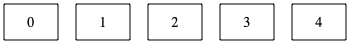

In [7]:
ddf.visualize()

## Write to a SQL DB <a id="serial-to-sql"></a>
Prepare to write to the DB:

In [8]:
res = ddf.to_sql(table, db, if_exists='replace', compute=False)

### Task Graph <a id="serial-graph"></a>
By default, each partition is written in serial:

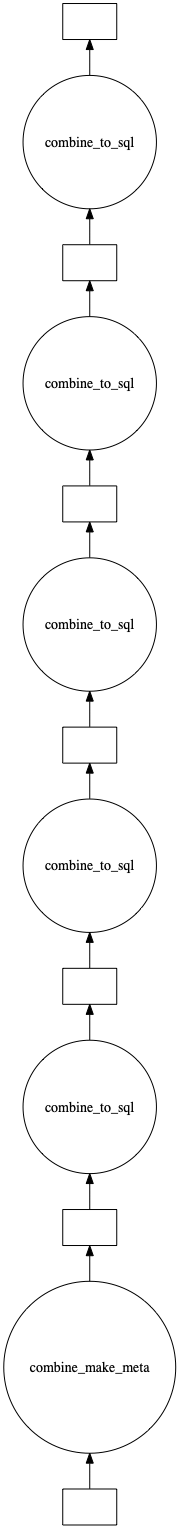

In [9]:
res.visualize()

`None`s are returned for each block:

In [10]:
res.compute()

Make meta (0)


[None, None, None, None, None, None]

### Verify the DB contents <a id="serial-db"></a>

In [11]:
read()

10 rows, 10 distinct


,i,s
index,,
0,0,00
1,1,11
2,2,22
3,3,33
4,4,44
5,5,55
6,6,66
7,7,77
8,8,88


## Writing blocks concurrently <a id="parallel"></a>
Passing `parallel=True` causes blocks to be written in parallel:

In [12]:
res = ddf.to_sql('test', 'sqlite:///test_db', if_exists='replace', parallel=True, compute=False)

This can be faster / more scalable, but generally causes the rows to end up out of order!

Depending on your use-case (and use of indexes at write- and read-time), that may not matter, but it's important to be aware of.

### Task Graph
"Meta" is written first, then all blocks are written concurrently (I'm not sure why they're all in the one `combine_list` node as opposed to the graph fanning out there):

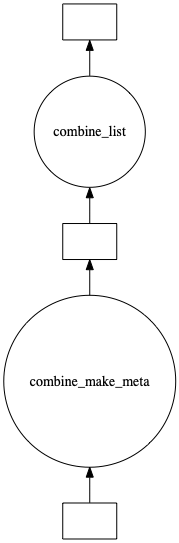

In [13]:
res.visualize()

### Compute

In [14]:
res.compute()

Make meta (0)


[None, [None, None, None, None, None]]

### Check the DB table <a id="parallel-db-table"></a>
Note that the rows are out of order!

In [15]:
read()

10 rows, 10 distinct


,i,s
index,,
6,6,66
7,7,77
2,2,22
3,3,33
0,0,00
1,1,11
4,4,44
5,5,55
8,8,88
